In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext Cython
%load_ext line_profiler
%load_ext memory_profiler


In [3]:
import sys, argparse, logging
from datetime import datetime, time
from decimal import Decimal
import pymongo
from pymongo import MongoClient
from tqdm import tqdm, tnrange, tqdm_notebook
import pandas as pd
from tmqr.settings import *
from tmqrfeed.assetsession import AssetSession
import pickle
import pytz
try:
    from tmqr.settings_local import *
except:
    pass
import pyximport

pyximport.install(setup_args={"include_dirs": np.get_include()})
from tmqrfeed.quotes.compress_daily_ohlcv import compress_daily
import os

from tmqrfeed.assetsession import AssetSession
from tmqrfeed.quotes.dataframegetter import DataFrameGetter
from tmqrfeed.datafeed import DataFeed
from tmqrfeed.manager import DataManager

In [4]:
dm = DataManager()
feed = dm.datafeed

In [10]:
chain = feed.get_fut_chain("US.CL")
chain_values = chain.get_list(datetime(2011, 1, 1))

In [11]:
chain_values    

,date_end,date_start
ticker,,
US.F.CL.G11.110120,2011-01-18,2010-12-17
US.F.CL.H11.110222,2011-02-18,2011-01-18
US.F.CL.J11.110322,2011-03-18,2011-02-18
US.F.CL.K11.110419,2011-04-15,2011-03-18
US.F.CL.M11.110520,2011-05-18,2011-04-15
US.F.CL.N11.110622,2011-06-20,2011-05-18
US.F.CL.Q11.110720,2011-07-18,2011-06-20
US.F.CL.U11.110822,2011-08-18,2011-07-18
US.F.CL.V11.110921,2011-09-19,2011-08-18


In [12]:
fut = chain.get_contract(datetime(2012, 1, 1))
fut2 = chain.get_contract(datetime(2012, 1, 1), offset=1)

In [13]:
series1 = dm.series_get(fut)
series2 = dm.series_get(fut2)

In [14]:
series  = dm.series_get(fut)

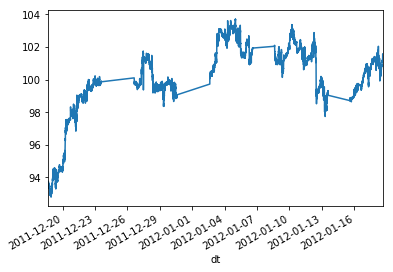

In [15]:
series.c.plot()

In [16]:
prev_series, position1  = compress_daily(DataFrameGetter(series1), fut)
new_series, position2  = compress_daily(DataFrameGetter(series2), fut2)

In [ ]:
series1.to_csv('fut_series_for_contfut1.csv.gz', compression='gzip')

In [ ]:
series2.to_csv('fut_series_for_contfut2.csv.gz', compression='gzip')

In [17]:
prev_series

,c,exec,h,l,o,v
dt,,,,,,
2011-12-19 10:40:00-08:00,94.05,94.11,94.63,93.23,93.35,100983.0
2011-12-20 10:40:00-08:00,97.47,97.39,97.61,94.75,94.77,151244.0
2011-12-21 10:40:00-08:00,98.63,98.53,99.25,96.80,98.19,142564.0
2011-12-22 10:40:00-08:00,99.77,99.85,100.05,98.51,99.21,92619.0
2011-12-23 10:40:00-08:00,99.71,99.72,100.22,99.56,99.98,51480.0
2011-12-27 10:40:00-08:00,101.20,101.25,101.39,99.49,99.51,59311.0
2011-12-28 10:40:00-08:00,99.68,99.65,101.50,99.11,101.02,95324.0
2011-12-29 10:40:00-08:00,99.71,99.56,99.92,98.30,99.55,91362.0
2011-12-30 10:40:00-08:00,99.69,99.71,100.11,98.61,99.33,70606.0


In [ ]:
new_series.c.sum()

In [ ]:
prev_prices = prev_series.loc[prev_series.index[-1]]
new_prices = new_series.loc[prev_series.index[-1]]

In [ ]:
prev_prices

In [ ]:
new_prices

In [ ]:
fut_offset = new_prices['exec'] - prev_prices['exec']

In [ ]:
fut_offset

In [ ]:
new_series[['o','h','l', 'c', 'exec']] -= fut_offset

In [ ]:
new_series = new_series[new_series.index > prev_series.index[-1]]

In [ ]:
pd.concat([prev_series, new_series])

In [ ]:
def merge(prev_series, new_series):
    try:
        prev_prices = prev_series.loc[prev_series.index[-1]]
        new_prices = new_series.loc[prev_series.index[-1]]
        # Calculating futures rollover factor
        fut_offset = new_prices['exec'] - prev_prices['exec']
    except KeyError:
        fut_offset = 0.0
        
    new_series[['o','h','l', 'c', 'exec']] -= fut_offset
    new_series = new_series[new_series.index > prev_series.index[-1]]
    return pd.concat([prev_series, new_series])

In [ ]:
%timeit compress_daily(DataFrameGetter(series), fut)

In [18]:
prev_series, position1  = compress_daily(DataFrameGetter(series), fut)
new_series, position2  = compress_daily(DataFrameGetter(series2), fut2)

In [ ]:
%lprun -f merge merge(prev_series, new_series)

In [ ]:
%timeit merge(prev_series, new_series)

In [ ]:
position1.at[position1.index[-1], 'qty'] = 0

In [ ]:
position1

In [ ]:
position2

In [ ]:
%%timeit
pd.merge(position2.reset_index(), position1.reset_index(), how='outer').sort_values('date').set_index(['date', 'asset'])

In [ ]:
position1.index.get_level_values('date')

In [5]:
from tmqrfeed.quotes.quote_contfut import QuoteContFut

In [6]:
qcont_fut = QuoteContFut('US.CL', datamanager=dm, timeframe='D')

In [8]:
%timeit contfut_df, contfut_position = qcont_fut.build()

1 loop, best of 3: 2.26 s per loop


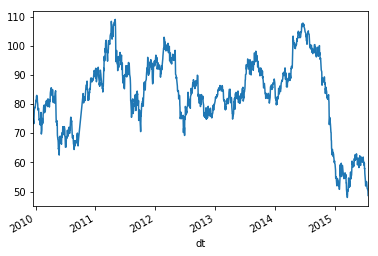

In [9]:
contfut_df.exec.plot()

In [ ]:
%lprun -m tmqrfeed.quotes.quote_contfut qcont_fut.build()

In [23]:
%timeit qcont_fut.build()

1 loop, best of 3: 2.92 s per loop


# Position caching benchmarks

In [11]:
p = contfut_position

In [12]:
%%timeit
p[(p.asset == 'US.F.CL.Q15.150721') & (p.index == pd.Timestamp('2015-06-22 10:40:00-07:00'))]

AttributeError: 'dict' object has no attribute 'asset'

In [14]:
p

{datetime.datetime(2009, 12, 18, 10, 40, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>): {US.F.CL.G10.100120: (74.63,
   74.77,
   1)},
 datetime.datetime(2009, 12, 21, 10, 40, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>): {US.F.CL.G10.100120: (73.46,
   73.29,
   1)},
 datetime.datetime(2009, 12, 22, 10, 40, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>): {US.F.CL.G10.100120: (74.64,
   74.63,
   1)},
 datetime.datetime(2009, 12, 23, 10, 40, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>): {US.F.CL.G10.100120: (76.42,
   76.49,
   1)},
 datetime.datetime(2009, 12, 24, 10, 40, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>): {US.F.CL.G10.100120: (440.25,
   78.05,
   1)},
 datetime.datetime(2009, 12, 28, 10, 40, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>): {US.F.CL.G10.100120: (78.84,
   78.89,
   1)},
 datetime.datetime(2009, 12, 29, 10, 40, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>): {US.F.CL.G10.100120: (78

In [61]:
%%mprun
pos_dic = {}
for i in range(len(p)):
    row = p.iloc[i]
    date_positions = pos_dic.setdefault(row['date'], {})
    
    date_positions[str(row['asset'])] = {'dpx': row['decision_px'], 'epx': row['exec_px'], 'qty': row['qty']}
    #print(row)

In [18]:
%%timeit 
try:
    p[pd.Timestamp('2015-06-22 10:40:00-07:00')]['US.F.CL.Q15.1507221']
except KeyError:
    pass

10000 loops, best of 3: 81.8 µs per loop


In [20]:
%%timeit 
r = p.get(pd.Timestamp('2015-06-22 10:40:00-07:00'), False)
if r:
    if 'US.F.CL.Q15.1507221' in r:
        pass

10000 loops, best of 3: 80.1 µs per loop


In [64]:
%timeit pickle.dumps(pos_dic)

10 loops, best of 3: 20.5 ms per loop


In [10]:
pos_dic[pd.Timestamp('2015-06-22 10:40:00-07:00')]['US.F.CL.Q15.1507212']

NameError: name 'pos_dic' is not defined